<a href="https://colab.research.google.com/github/piratesdragon/ML-homework/blob/main/ml_homework7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашняя работа 7

## Подготовим данные

In [1]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
wine = pd.read_csv("/content/drive/MyDrive/winemag-data-130k-v2.csv")
wine.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129971 entries, 0 to 129970
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                129908 non-null  object 
 1   description            129971 non-null  object 
 2   designation            92506 non-null   object 
 3   points                 129971 non-null  int64  
 4   price                  120975 non-null  float64
 5   province               129908 non-null  object 
 6   region_1               108724 non-null  object 
 7   region_2               50511 non-null   object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                129970 non-null  object 
 12  winery                 129971 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 12.9+ MB


Датасет очень большой, для более быстрых подсчетов сократим его.

In [4]:
wine = wine.sample(n=20000, random_state=42)

In [5]:
# Оставляем информативные колонки

wine = wine[['country', 'province','points', 'price', 'variety']]

In [6]:
wine.isna().any()

country      True
province     True
points      False
price        True
variety     False
dtype: bool

In [7]:
print(wine.shape)
wine = wine.dropna()
wine.shape

(20000, 5)


(18596, 5)

In [8]:
wine.reset_index(inplace=True)

In [9]:
wine.drop(['index'], axis=1, inplace=True)

Колонки Country, Province и Variety текстовые, но их легко можно перевести в категориальные - кажется, что для задачи кластеризации это имеет смысл.

In [10]:
countries = {label:idx for idx, label in enumerate(wine['country'].unique())}
provinces = {label:idx for idx, label in enumerate(wine['province'].unique())}
varieties = {label:idx for idx, label in enumerate(wine['variety'].unique())}

In [11]:
wine['country'] = wine['country'].replace(countries)
wine['province'] = wine['province'].replace(provinces)
wine['variety'] = wine['variety'].replace(varieties)

In [12]:
wine.head()

,country,province,points,price,variety
0,0,0,83,5.0,0
1,1,1,85,12.0,1
2,2,2,86,9.0,2
3,3,3,87,29.0,3
4,3,3,88,40.0,4


Нормализуем данные

In [13]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
wine_scaled = wine.copy()
wine_scaled[wine_scaled.columns]=sc.fit_transform(wine_scaled)

In [14]:
wine_scaled.head()

,country,province,points,price,variety
0,-1.218400,-0.690361,-1.764763,-0.726049,-0.611937
1,-0.899816,-0.663077,-1.113098,-0.559024,-0.593705
2,-0.581232,-0.635793,-0.787265,-0.630606,-0.575473
3,-0.262648,-0.608510,-0.461433,-0.153391,-0.557240
4,-0.262648,-0.608510,-0.135600,0.109077,-0.539008


Посмотрим, как коррелируют друг с другом разные параметры

<Axes: >

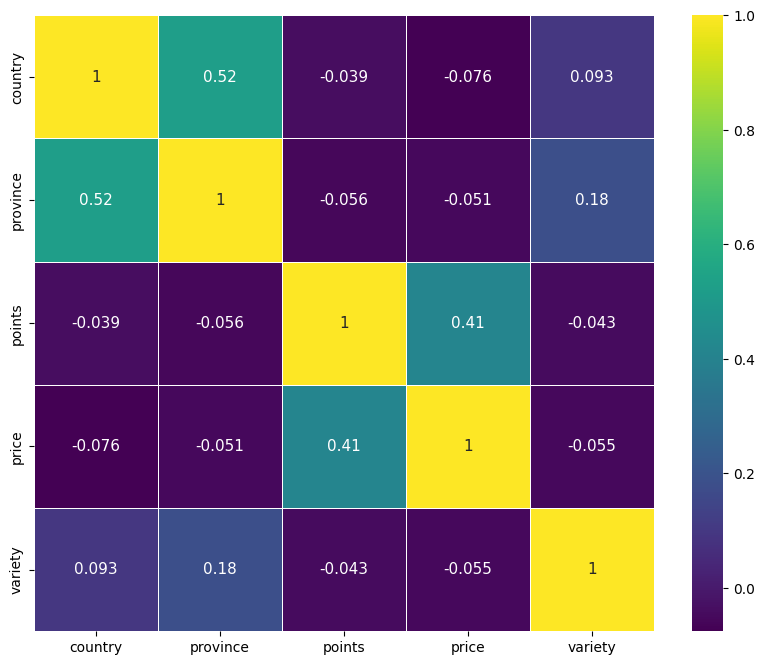

In [15]:
corr = wine_scaled.corr()

plt.figure(figsize=(10,8))

sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True,annot_kws={"size": 11})

Очевидно, что провинция коррелирует со страной и видом вина. Также ожидаема взаимосвязь цены и оценки.

Для облегчения дальнейшей работы с алгоритмами кластеризации уменьшим размерность датасета.

In [22]:
pca = PCA(2)
wine_pca = pca.fit_transform(wine_scaled[['country','province','points','price','variety']])
wine_pca.shape

(18596, 2)

In [24]:
wine_pca

array([[ 0.49310361, -2.2343318 ],
       [ 0.5511213 , -1.60723845],
       [ 0.4243872 , -1.33310225],
       ...,
       [ 0.74119563, -0.15578962],
       [-0.88068254, -0.23523964],
       [ 0.87495341,  0.02434232]])

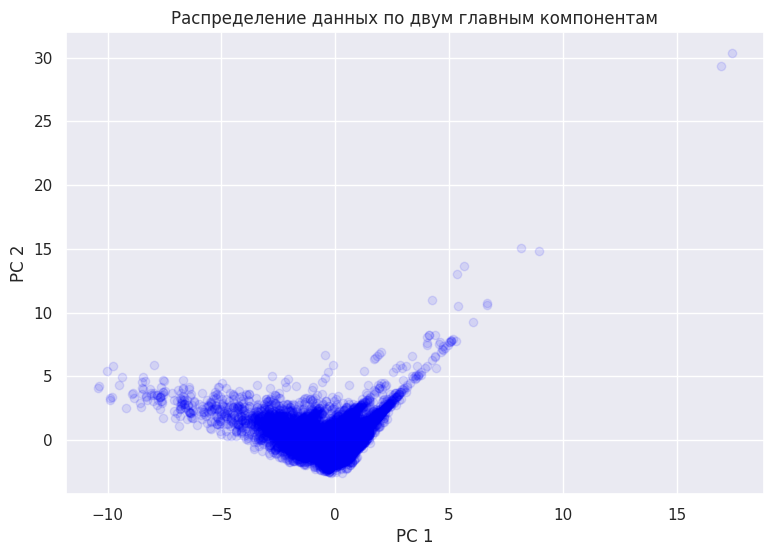

In [29]:
sns.set(rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=wine_pca[:, 0], y=wine_pca[:, 1], color='blue', alpha=0.1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

## K-means

In [30]:
from sklearn.metrics import silhouette_score
import sklearn.cluster as cluster
from tqdm.notebook import tqdm,trange

In [33]:
for i in trange(5,206,25):
  kmeans = cluster.KMeans(n_clusters = i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17
    )

  kmeans.fit(wine_pca)
  inertia = kmeans.inertia_
  silhouette = silhouette_score(wine_pca, kmeans.labels_, metric='euclidean')
  print(f'Number of clusters={i}, inertia = {inertia}, silhouette = {silhouette}')

  0%|          | 0/9 [00:00<?, ?it/s]

Number of clusters=5, inertia = 15918.814832745229, silhouette = 0.4298001619324246
Number of clusters=30, inertia = 2155.2785384698027, silhouette = 0.36365385255488647
Number of clusters=55, inertia = 1181.189276103572, silhouette = 0.35143046934533034
Number of clusters=80, inertia = 794.0504407394981, silhouette = 0.34963073314515314
Number of clusters=105, inertia = 578.3477002707416, silhouette = 0.3630625522150409
Number of clusters=130, inertia = 457.82187563094976, silhouette = 0.36699400373144225
Number of clusters=155, inertia = 378.6308798374848, silhouette = 0.36266215510380295
Number of clusters=180, inertia = 320.06930628947237, silhouette = 0.3607522443616115
Number of clusters=205, inertia = 279.13277626227034, silhouette = 0.365727394801706


Возьмем число кластеров=130 - он дает довольно низкий показатель инерции и довольно высокий показатель silhouette score.

In [42]:
kmeans = cluster.KMeans(n_clusters=130,random_state=17,init='k-means++')

kmeans_labels = kmeans.fit_predict(wine_pca)

centroids = kmeans.cluster_centers_ # центры кластеров

display(pd.Series(kmeans_labels).value_counts()[0:10]) # кол-во вин по кластерам


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


46     581
6      565
15     560
123    530
54     497
55     488
115    479
78     475
75     467
71     460
dtype: int64

In [43]:
wine_pca_df=pd.DataFrame(wine_pca)
wine_pca_df['Cluster']=kmeans_labels

In [44]:
wine_pca_df

,0,1,Cluster
0,0.493104,-2.234332,125
1,0.551121,-1.607238,61
2,0.424387,-1.333102,61
3,0.483738,-0.720397,6
4,0.671151,-0.351163,71
...,...,...,...
18591,0.537235,-0.168161,36
18592,0.316921,-0.847903,46
18593,0.741196,-0.155790,15
18594,-0.880683,-0.235240,65


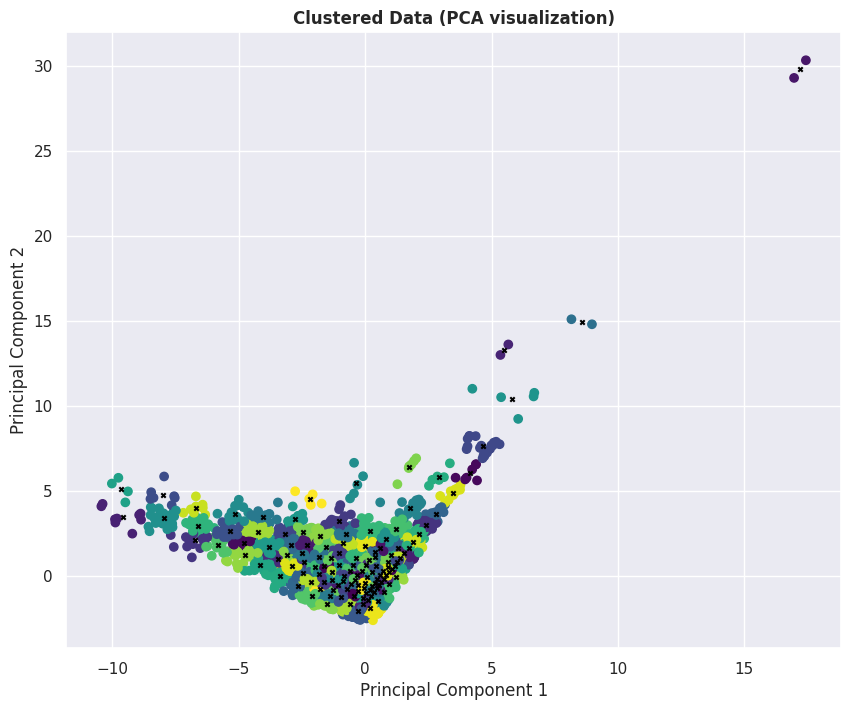

In [45]:
sns.set( rc={'figure.figsize':(10,8)},font_scale=1)

plt.scatter(x=wine_pca[:, 0], y=wine_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=10, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

Некоторые отдельностоящие кластеры определяются хорошо, но кластеры, близкие к 0, очень близко друг к другу

## MeanShift

In [51]:
from sklearn.cluster import MeanShift
import sklearn
from sklearn.metrics import silhouette_score


In [47]:
sklearn.cluster.estimate_bandwidth(wine_scaled)


1.8949818565046754

In [48]:
cluster = MeanShift(cluster_all=False, bandwidth=1.87)
cluster.fit(wine_scaled)

MeanShift(bandwidth=1.87, cluster_all=False)

In [49]:
len(set(cluster.labels_))


29

In [54]:
print("Silhouette Score: %0.3f" % silhouette_score(wine_scaled, cluster.labels_))

Silhouette Coefficient: 0.308


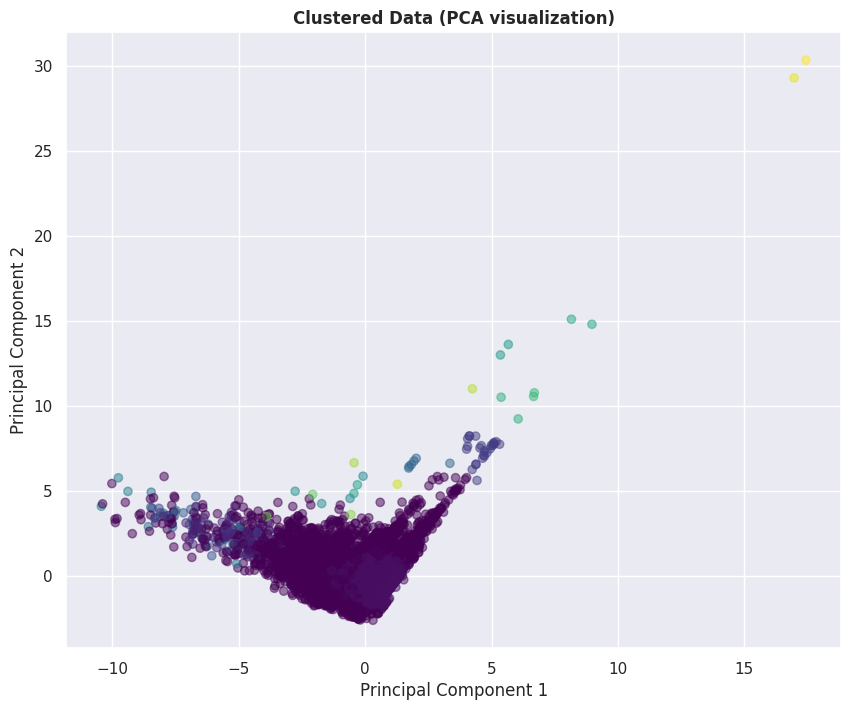

In [61]:
sns.set( rc={'figure.figsize':(10,8)},font_scale=1)

plt.scatter(x=wine_pca[:, 0], y=wine_pca[:, 1], c=cluster.labels_, cmap='viridis', alpha=0.5)
# plt.scatter(centroids[:, 0], centroids[:, 1],
#             marker='x', s=10, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

Видно, что большая часть вин отнесена к одному кластеру.